In [ ]:
!pip install torch transformers datasets

## Dataset

We will start by initializing an image dataset from Hugging Face.

In [1]:
from datasets import load_dataset

imagenette = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='train',
    ignore_verifications=False  # set to True if seeing splits Error
)
imagenette

Reusing dataset imagenette (/Users/jamesbriggs/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)


Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

It contains *9469* records, we're only interested in the `'image'` feature which contains PIL image objects covering a variety of things like radios and dogs.

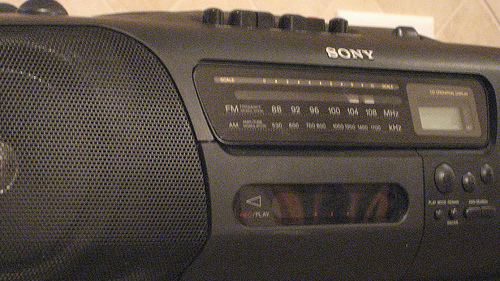

In [2]:
imagenette[0]['image']

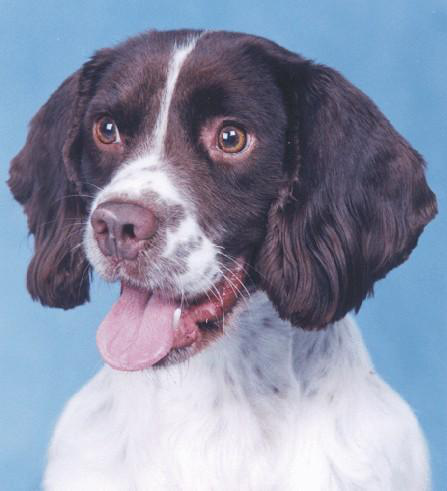

In [3]:
imagenette[6494]['image']

## Initializing CLIP

We also use Hugging Face for CLIP, via the `transformers` library.

In [4]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# if you have CUDA or MPS, set it to the active device like this
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"

tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

We can create text embeddings like so:

In [5]:
prompt = "a dog in the snow"

# create transformer-readable tokens
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  1929,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [6]:
# use CLIP to encode tokens into a meaningful embedding
text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

This 512-dimensional vector represents the "semantic meaning" of the phrase.

To create the same from an image we do this:

In [7]:
image = processor(
    text=None,
    images=imagenette[0]['image'],
    return_tensors='pt',
    padding=True
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

/var/folders/g7/qd2j76kn64ggrl4ym2vlvzwr0000gn/T/ipykernel_6748/1134881401.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3074.)
  plt.imshow(image.squeeze(0).T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


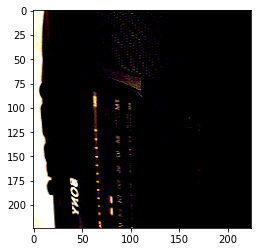

In [8]:
import matplotlib.pyplot as plt
# we can still visualize the processed image
plt.imshow(image.squeeze(0).T)

In [9]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

Now we have both representing in vector space. We can do this for a set of images and then use a metric like *Euclidean distance*, *cosine similarity*, or *dot product similarity* to compare them.

Let's take a small sample of `100` images, embed them, and search using our query.

In [10]:
import numpy as np

np.random.seed(0)
# select 100 random image index values
sample_idx = np.random.randint(0, len(imagenette)+1, 100).tolist()
# extract the image sample from the dataset
images = [imagenette[i]['image'] for i in sample_idx]

Now we create the embeddings.

In [11]:
from tqdm.auto import tqdm

batch_size = 16
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
    # select batch of images
    batch = images[i:i+batch_size]
    # process and resize
    batch = processor(
        text=None,
        images=batch,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batch)
    # convert to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    # add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)
image_arr.shape

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/7 [00:00<?, ?it/s]

(100, 512)

In [12]:
image_arr.min(), image_arr.max()

(-7.994915, 3.1525095)

We must also normalize these vectors so that we can compare them *accurately* with dot product similarity.

In [13]:
np.linalg.norm(image_arr, axis=1).shape

(100,)

In [14]:
image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)
image_arr.min(), image_arr.max()

(-0.6996712, 0.31254983)

Now we use dot product to compare these image embeddings to our initial text embedding of `"dogs in the snow"`.

In [15]:
text_emb = text_emb.cpu().detach().numpy()
scores = np.dot(text_emb, image_arr)
scores.shape

(1, 100)

Now we find the index values of the top scoring items, we can then map this to the top most similar images stored in `images`.

In [16]:
top_k = 5
# get the top k indices for most similar vecs
idx = np.argsort(-scores[0])[:top_k]
idx

array([71, 24, 86, 76, 85])

71: 2.42515230178833


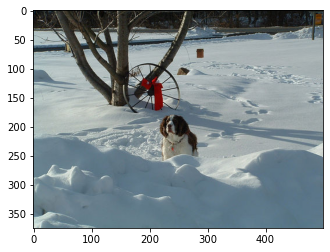

24: 2.219564437866211


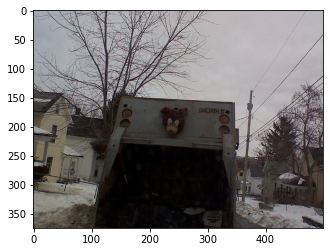

86: 1.8799803256988525


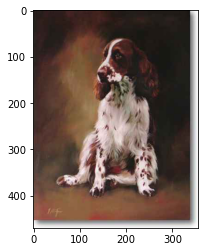

76: 1.7686570882797241


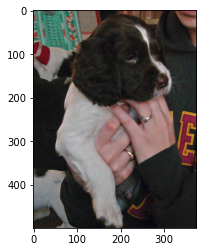

85: 1.733044147491455


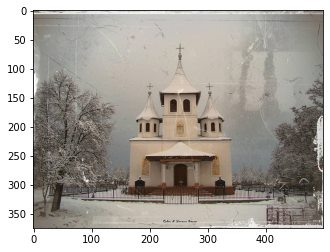

In [17]:
import matplotlib.pyplot as plt

# display the results
for i in idx:
    print(f"{i}: {scores[0][i]}")
    plt.imshow(images[i], cmap='gray')
    plt.show()

And there we have a text-image search. The order in which we use these datatypes does not matter as in the end we're performing vector-to-vector comparisons. That means that if you want to perform image-image search, text-text search, or image-text search, you follow the exact same steps.

---